In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

# 프로젝트 폴더 생성
project_dir = "/content/CSRNet_BoxCounting"
os.makedirs(project_dir, exist_ok=True)

images_dir = f"{project_dir}/dataset/images"
labels_dir = f"{project_dir}/dataset/labels"
density_dir = f"{project_dir}/dataset/density"

os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)
os.makedirs(density_dir, exist_ok=True)

print("폴더 준비 완료:", project_dir)


Mounted at /content/drive
폴더 준비 완료: /content/CSRNet_BoxCounting


In [4]:
from google.colab import files
uploaded = files.upload()

# 업로드된 파일들을 자동으로 정리
import shutil

for file in uploaded.keys():
    if file.endswith(".jpg") or file.endswith(".png"):
        shutil.move(file, images_dir + "/" + file)
    elif file.endswith(".json"):
        shutil.move(file, labels_dir + "/" + file)

print("업로드 완료")


Saving S_box_img_0000.json to S_box_img_0000.json
Saving S_box_img_0004.json to S_box_img_0004.json
Saving S_box_img_0005.json to S_box_img_0005.json
Saving S_box_img_0006.json to S_box_img_0006.json
Saving S_box_img_0007.json to S_box_img_0007.json
Saving S_box_img_0008.json to S_box_img_0008.json
Saving S_box_img_0009.json to S_box_img_0009.json
Saving S_box_img_0010.json to S_box_img_0010.json
Saving S_box_img_0011.json to S_box_img_0011.json
Saving S_box_img_0012.json to S_box_img_0012.json
Saving S_box_img_0013.json to S_box_img_0013.json
Saving S_box_img_0014.json to S_box_img_0014.json
Saving S_box_img_0015.json to S_box_img_0015.json
Saving S_box_img_0016.json to S_box_img_0016.json
Saving S_box_img_0017.json to S_box_img_0017.json
Saving S_box_img_0018.json to S_box_img_0018.json
Saving S_box_img_0019.json to S_box_img_0019.json
Saving S_box_img_0020.json to S_box_img_0020.json
Saving S_box_img_0021.json to S_box_img_0021.json
Saving S_box_img_0022.json to S_box_img_0022.json


In [5]:
!pip install torch torchvision scipy opencv-python-headless

In [18]:
import numpy as np
from scipy.ndimage import gaussian_filter
import json, cv2, os
from glob import glob

TARGET_W, TARGET_H = 640, 480   # width, height
SIGMA = 8                       # 권장 sigma


def generate_density_map(img_path, json_path, sigma=SIGMA):
    # 원본 이미지 읽기
    img = cv2.imread(img_path)
    if img is None:
        print("[ERROR] 이미지 읽기 실패:", img_path)
        return None

    orig_h, orig_w = img.shape[:2]

    # resize
    img_resized = cv2.resize(img, (TARGET_W, TARGET_H))
    resized_h, resized_w = img_resized.shape[:2]

    # 빈 density 맵
    density = np.zeros((resized_h, resized_w), dtype=np.float32)

    # VIA JSON 읽기
    with open(json_path, "r") as f:
        via = json.load(f)

    key = list(via.keys())[0]
    regions = via[key]["regions"]

    # 점 찍기 (좌표 스케일링 필수)
    for r in regions:
        s = r["shape_attributes"]
        cx = s["cx"]
        cy = s["cy"]

        # 스케일링
        x = int(cx * (TARGET_W / orig_w))
        y = int(cy * (TARGET_H / orig_h))

        if 0 <= x < TARGET_W and 0 <= y < TARGET_H:
            density[y, x] += 1

    # Gaussian Blur
    density = gaussian_filter(density, sigma=sigma)

    # CSRNet 출력에 맞게 1/8 축소 (80, 60)
    density = cv2.resize(density, (TARGET_W // 8, TARGET_H // 8), interpolation=cv2.INTER_AREA)

    return density



def generate_all_density(img_dir, lbl_dir, dens_dir):
    os.makedirs(dens_dir, exist_ok=True)

    for img_path in sorted(glob(os.path.join(img_dir, "*.jpg"))):
        name = os.path.basename(img_path)

        json_path = os.path.join(lbl_dir, name.replace(".jpg", ".json"))

        if not os.path.exists(json_path):
            print("[WARN] JSON 없음:", json_path)
            continue

        dmap = generate_density_map(img_path, json_path)
        if dmap is not None:
            np.save(os.path.join(dens_dir, name.replace(".jpg", "_density.npy")), dmap)
            print("[OK] 저장:", name)



# 실행
generate_all_density(images_dir, labels_dir, density_dir)
print("모든 density map 생성 완료!")


[OK] 저장: S_box_img_0000.jpg
[OK] 저장: S_box_img_0001.jpg
[OK] 저장: S_box_img_0002.jpg
[OK] 저장: S_box_img_0003.jpg
[OK] 저장: S_box_img_0004.jpg
[OK] 저장: S_box_img_0005.jpg
[OK] 저장: S_box_img_0006.jpg
[OK] 저장: S_box_img_0007.jpg
[OK] 저장: S_box_img_0008.jpg
[OK] 저장: S_box_img_0009.jpg
[OK] 저장: S_box_img_0010.jpg
[OK] 저장: S_box_img_0011.jpg
[OK] 저장: S_box_img_0012.jpg
[OK] 저장: S_box_img_0013.jpg
[OK] 저장: S_box_img_0014.jpg
[OK] 저장: S_box_img_0015.jpg
[OK] 저장: S_box_img_0016.jpg
[OK] 저장: S_box_img_0017.jpg
[OK] 저장: S_box_img_0018.jpg
[OK] 저장: S_box_img_0019.jpg
[OK] 저장: S_box_img_0020.jpg
[OK] 저장: S_box_img_0021.jpg
[OK] 저장: S_box_img_0022.jpg
[OK] 저장: S_box_img_0023.jpg
[OK] 저장: S_box_img_0024.jpg
[OK] 저장: S_box_img_0025.jpg
[OK] 저장: S_box_img_0026.jpg
[OK] 저장: S_box_img_0027.jpg
[OK] 저장: S_box_img_0028.jpg
[OK] 저장: S_box_img_0029.jpg
[OK] 저장: S_box_img_0030.jpg
[OK] 저장: S_box_img_0031.jpg
[OK] 저장: S_box_img_0032.jpg
[OK] 저장: S_box_img_0033.jpg
[OK] 저장: S_box_img_0034.jpg
[OK] 저장: S_box_img_0

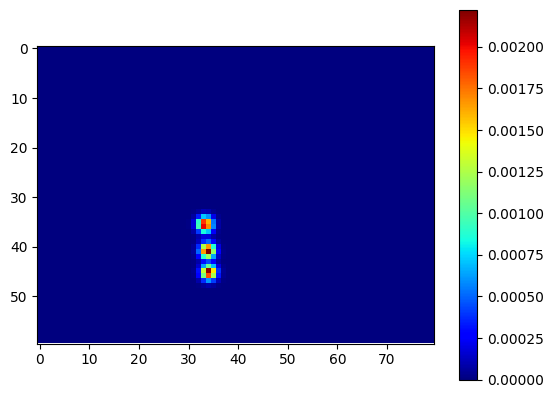

In [31]:
d = np.load("/content/CSRNet_BoxCounting/dataset/density/S_box_img_0000_density.npy")
plt.imshow(d, cmap='jet')
plt.colorbar()
plt.show()


In [7]:
import torch
import torch.nn as nn
import torchvision.models as models

class CSRNet(nn.Module):
    def __init__(self, pretrained=True):
        super(CSRNet, self).__init__()

        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
        frontend = list(vgg.features.children())[:33]
        self.frontend = nn.Sequential(*frontend)

        backend = [
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(True),
        ]
        self.backend = nn.Sequential(*backend)

        self.output_layer = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x


In [19]:
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import cv2
from glob import glob
import torch

class BoxDataset(Dataset):
    def __init__(self, img_dir, dens_dir, target_size=(640,480)):
        self.img_paths = sorted(glob(os.path.join(img_dir, "*.jpg")))
        self.dens_dir = dens_dir
        self.target_size = target_size

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((target_size[1], target_size[0])),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485,0.456,0.406],
                std=[0.229,0.224,0.225]
            ),
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        name = os.path.basename(img_path)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = self.transform(img)

        den = np.load(os.path.join(self.dens_dir, name.replace(".jpg", "_density.npy")))
        den = torch.tensor(den).unsqueeze(0).float()

        return img, den


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

dataset = BoxDataset(images_dir, density_dir)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CSRNet().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

EPOCHS = 1000

for epoch in range(EPOCHS):
    total_loss = 0

    for img, den in loader:
        img = img.to(device)
        den = den.to(device)

        pred = model(img)

        loss = criterion(pred, den)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[{epoch+1}/{EPOCHS}] Loss: {total_loss:.8f}")

torch.save(model.state_dict(), f"{project_dir}/csrnet.pth")
print("모델 저장 완료:", f"{project_dir}/csrnet.pth")


[1/1000] Loss: 0.35916536
[2/1000] Loss: 0.01967601
[3/1000] Loss: 0.00678688
[4/1000] Loss: 0.00178484
[5/1000] Loss: 0.00086984
[6/1000] Loss: 0.00062051
[7/1000] Loss: 0.00050286
[8/1000] Loss: 0.00041299
[9/1000] Loss: 0.00036177
[10/1000] Loss: 0.00031080
[11/1000] Loss: 0.00028099
[12/1000] Loss: 0.00023108
[13/1000] Loss: 0.00020313
[14/1000] Loss: 0.00018778
[15/1000] Loss: 0.00018143
[16/1000] Loss: 0.00018812
[17/1000] Loss: 0.00013914
[18/1000] Loss: 0.00013119
[19/1000] Loss: 0.00012540
[20/1000] Loss: 0.00010193
[21/1000] Loss: 0.00009728
[22/1000] Loss: 0.00010049
[23/1000] Loss: 0.00009127
[24/1000] Loss: 0.00008519
[25/1000] Loss: 0.00009491
[26/1000] Loss: 0.00007352
[27/1000] Loss: 0.00006768
[28/1000] Loss: 0.00006768
[29/1000] Loss: 0.00006660
[30/1000] Loss: 0.00006562
[31/1000] Loss: 0.00005393
[32/1000] Loss: 0.00005202
[33/1000] Loss: 0.00004833
[34/1000] Loss: 0.00005100
[35/1000] Loss: 0.00005056
[36/1000] Loss: 0.00004989
[37/1000] Loss: 0.00005291
[38/1000] 

In [40]:
print("min:", dmap.min())
print("max:", dmap.max())
print("sum:", dmap.sum())
print("mean:", dmap.mean())


min: -0.00012912229
max: 0.0014394987
sum: 0.19132319
mean: 3.9859e-05


예측할 이미지 파일: /content/CSRNet_BoxCounting/dataset/images/S_box_img_0010.jpg
예측 개수: 0


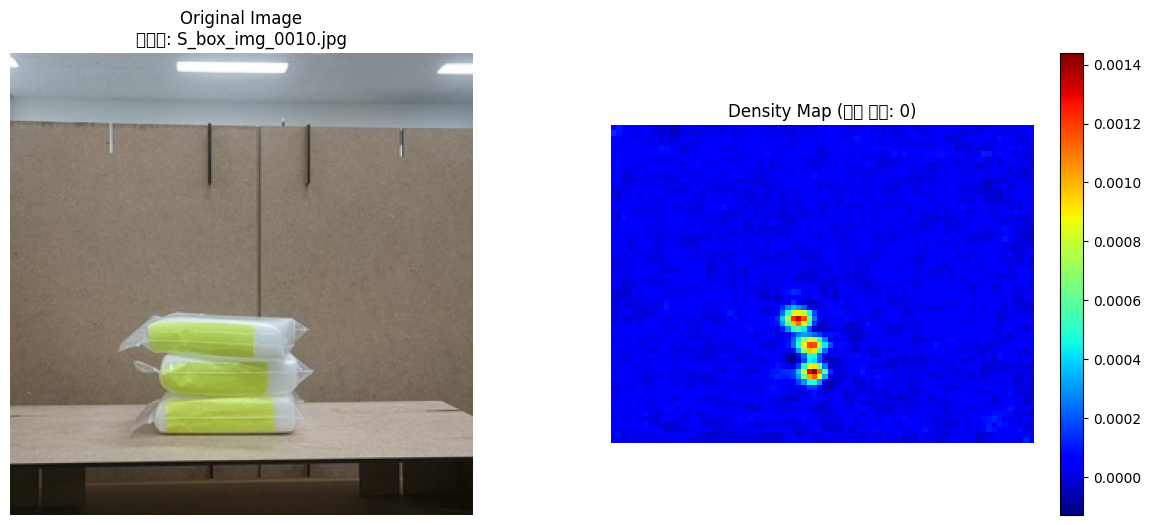

In [38]:
import torch
import cv2
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os

# 모델 로드
model_path = f"{project_dir}/csrnet.pth"
model = CSRNet(pretrained=False).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# 이미지 전처리
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((480,640)),  # CSRNet 입력
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    ),
])

# 테스트 이미지 선택
test_img = sorted(glob("/content/CSRNet_BoxCounting/dataset/images/S_box_img_0010.jpg"))[0]
print("예측할 이미지 파일:", test_img)

# 이미지 읽기
img = cv2.imread(test_img)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 변환
inp = transform(img_rgb).unsqueeze(0).to(device)

# 예측
with torch.no_grad():
    dmap = model(inp).cpu().numpy()[0][0]


count = round(dmap.sum())
print("예측 개수:", count)

# ==========================
# 📌 시각화
# ==========================
plt.figure(figsize=(15,6))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title(f"Original Image\n파일명: {os.path.basename(test_img)}")
plt.axis('off')

# Density map
plt.subplot(1, 2, 2)
plt.imshow(dmap, cmap='jet')
plt.title(f"Density Map (예측 개수: {count})")
plt.colorbar()
plt.axis('off')

plt.show()


In [39]:
import cv2
import torch
from torchvision import transforms

model = CSRNet(pretrained=False).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((480,640)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    ),
])

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    inp = transform(rgb).unsqueeze(0).to(device)

    with torch.no_grad():
        dmap = model(inp).cpu().numpy()[0][0]

    cnt = int(dmap.sum())
    cv2.putText(frame, f"Count: {cnt}", (20,40), cv2.FONT_HERSHEY_SIMPLEX,
                1.2, (0,255,0), 2)

    cv2.imshow("CSRNet Webcam", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
